<a href="https://colab.research.google.com/github/PratikWayase/PratikWayase/blob/main/text_classification_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q comet_ml transformers datasets gradio


In [ ]:
import comet_ml

comet_ml.init(api_key="your api key")

In [ ]:
import comet_ml

# Initializing the project
comet_ml.init(project_name="text-classification-with-transformers")

In [ ]:
from huggingface_hub import notebook_login

# Logining Hugging Face
notebook_login()


In [ ]:
from datasets import load_dataset

# Loading the dataset
raw_datasets = load_dataset("rotten_tomatoes")

raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
#Looking at the first sample of the training set
raw_datasets["train"][0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

In [ ]:
#First, let me convert the data into Pandas DataFrame with the set_format method as follows:

import pandas as pd

# Converting the dataset into Pandas dataframe
raw_datasets.set_format(type="pandas")
df = raw_datasets["train"][:]
df.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


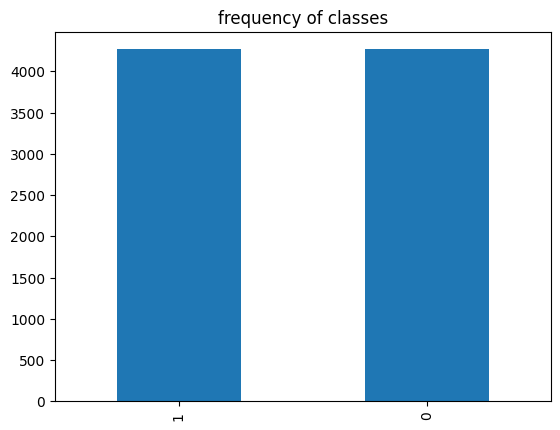

In [ ]:


# Visualizing the frequency of classes

import matplotlib.pyplot as plt
df["label"].value_counts(ascending = True).plot.bar()
plt.title("frequency of classes")
plt.show()

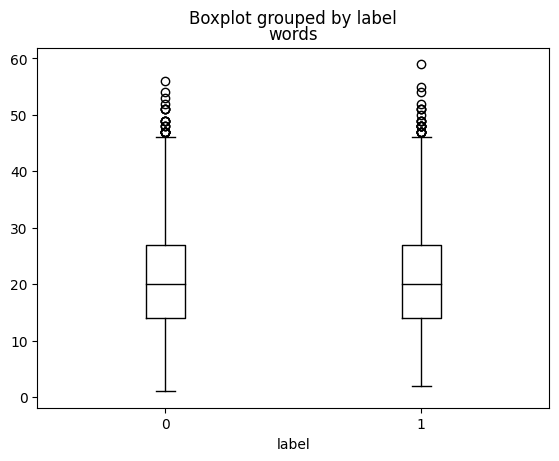

In [ ]:


#visulaize words per view
df["words"] = df["text"].str.split().apply(len)
df.boxplot("words",by = 'label',grid=False,color = "black")
plt.show()

In [ ]:

# Reseting the dataset format
raw_datasets.reset_format()

In [ ]:
#data preprocessing
from transformers import AutoTokenizer
#load Distilbert toeknizer
toekn = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(toekn)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#create function for tokenization
def tokenizer_function(example):
    return tokenizer(example["text"],truncation = True)

#apply function to entire dataset
tokenized_datasets = raw_datasets.map(tokenizer_function,batched = True)


#we tokenized our datasets. It’s time to create a batch of examples with DataCollatorWithPadding.
from transformers import DataCollatorWithPadding

# Padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# evaluation

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Indexing to example function
def get_example(index):
    return tokenized_datasets["test"][index]["text"]

# Creating a function to compute metrics
def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment()

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="macro")

    acc = accuracy_score(labels, preds)

    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            file_name=f"confusion-matrix-epoch-{epoch}.json",
            labels=["negative", "positive"],
            index_to_example_function=get_example)

    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}



In [ ]:
#building the Transformer Model
from transformers import AutoModelForSequenceClassification

# Mapping ids to labels
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# Building the model
model = AutoModelForSequenceClassification.from_pretrained(
              toekn, num_labels=2, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.5 MB/s eta 0:00:00


# Training


In [ ]:



import accelerate
import torch
print(accelerate.__version__)
print(torch.__version__)


0.25.0
2.1.0+cu121


In [ ]:
from transformers import TrainingArguments, Trainer

# Setting Comet enviroment variables
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE

# Setting training arguments
training_args = TrainingArguments(
    output_dir="my_distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    report_to=["comet_ml"],
)

# Creating a trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

# Training the model
trainer.train()
